In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn import model_selection, datasets, neighbors
from sklearn.metrics import accuracy_score, recall_score, precision_score, plot_confusion_matrix, confusion_matrix, balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler
from statistics import stdev,mean

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
data = pd.read_csv('/content/features_SNe_less_100_withoutna_v7.0.1.csv',index_col=0)
data

,index,Amplitude_2,AndersonDarling_2,Autocor_length_2,Beyond1Std_2,Con_2,Eta_e_2,ExcessVar_2,GP_DRW_sigma_2,GP_DRW_tau_2,Gskew_2,Harmonics_mag_1_1,Harmonics_mag_1_2,Harmonics_mag_2_1,Harmonics_mag_2_2,Harmonics_mag_3_1,Harmonics_mag_3_2,Harmonics_mag_4_1,Harmonics_mag_4_2,Harmonics_mag_5_1,Harmonics_mag_5_2,Harmonics_mag_6_1,Harmonics_mag_6_2,Harmonics_mag_7_1,Harmonics_mag_7_2,Harmonics_mse_1,Harmonics_mse_2,Harmonics_phase_2_1,Harmonics_phase_2_2,Harmonics_phase_3_1,Harmonics_phase_3_2,Harmonics_phase_4_1,Harmonics_phase_4_2,Harmonics_phase_5_1,Harmonics_phase_5_2,Harmonics_phase_6_1,Harmonics_phase_6_2,Harmonics_phase_7_1,Harmonics_phase_7_2,IAR_phi_2,...,SPM_tau_fall_1,SPM_tau_fall_2,SPM_tau_rise_1,SPM_tau_rise_2,Skew_2,SmallKurtosis_2,Std_2,StetsonK_2,delta_mag_fid_1,delta_mag_fid_2,delta_mjd_fid_1,delta_mjd_fid_2,delta_period_2,first_mag_1,first_mag_2,g-r_max,g-r_mean,gal_b,gal_l,iqr_1,iqr_2,mean_mag_1,mean_mag_2,min_mag_1,min_mag_2,n_det_1,n_det_2,n_neg_1,n_neg_2,n_non_det_after_fid_1,n_non_det_after_fid_2,n_non_det_before_fid_1,n_non_det_before_fid_2,n_pos_1,n_pos_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,classALeRCE
0,ZTF18aahvndq,1.181929,0.816488,3.0,0.375000,0.0,0.336763,0.002284,0.759127,27.722386,-0.545918,1.463030e+00,1.165342e+00,3.306317e-01,4.825615e-01,4.088558e-02,3.633719e-01,6.279649e-02,1.297324e-01,9.803265e-02,1.589627e-01,7.248764e-02,1.108749e-01,3.504948e-02,9.910195e-02,1.269572e-04,2.430668e-07,2.330903,1.307609,3.581321,2.973612,1.530842,3.730764,3.013248,4.866339,4.353741,5.874091,5.558791,1.953430,0.956890,...,28.120059,25.246280,27.809313,33.254714,-0.273266,-1.025352,0.800511,0.906851,3.096202,2.363857,65.029468,66.918588,77.112657,16.912367,17.686811,-0.041541,0.246432,84.778146,32.955580,2.260997,1.417577,16.971390,16.724958,15.385100,15.426641,17.0,16.0,0.0,0.0,0.0,1.0,9.0,9.0,17.0,16.0,1.0,1.0,0.882857,0.175976,SNIa
1,ZTF19abqviuy,0.948517,0.845792,3.0,0.250000,0.0,0.067101,0.000727,0.542256,92.358618,0.801962,3.063041e+05,2.107556e+01,2.101844e+05,2.340180e+01,5.277239e+05,2.146993e+01,4.914994e+05,1.562303e+01,2.691696e+05,8.843119e+00,8.712295e+04,3.604490e+00,1.319910e+04,8.080676e-01,1.295592e-14,2.502968e-04,2.624460,6.089589,2.672650,5.690627,2.573672,5.206934,2.449959,4.674494,2.306935,4.083724,2.131211,3.397194,0.980776,...,12.060586,24.307115,5.000824,4.856172,0.885575,1.323088,0.515389,0.877596,1.723713,1.897034,29.948750,60.822778,0.000000,18.498821,18.892059,-0.079273,-0.077818,-56.280175,109.009057,1.445135,0.620457,18.705450,18.783268,18.078302,18.157576,13.0,16.0,0.0,0.0,2.0,1.0,7.0,5.0,13.0,16.0,1.0,1.0,0.931429,0.500000,SNIa
2,ZTF19acyogrm,0.928749,0.983658,5.0,0.400000,0.0,0.001284,0.000932,0.385131,49.747288,-0.572072,7.156683e+00,1.224361e+00,4.098432e+00,7.963011e-01,5.662959e-01,4.386657e-01,2.242174e+00,4.298199e-01,2.769679e+00,4.119624e-01,9.581221e-01,3.257489e-01,2.907409e+00,1.368768e-01,2.297163e-28,4.623270e-04,0.026502,1.321037,0.597341,2.166498,2.916803,2.871322,2.949353,3.635897,2.624821,4.204936,0.237635,5.019764,0.976345,...,15.334865,27.176324,2.796403,2.705225,-0.397804,-0.793577,0.573871,0.894449,0.756476,1.876707,16.977593,65.897951,0.000000,19.623400,18.870781,1.280890,0.400809,-24.613587,148.867482,0.180983,0.847462,19.141043,18.638594,18.866925,17.639597,5.0,25.0,0.0,0.0,18.0,5.0,18.0,15.0,5.0,25.0,1.0,1.0,0.850000,0.332214,SNIbc
3,ZTF20aaiovoy,0.327079,0.996793,3.0,0.190476,0.0,0.255427,0.000064,0.025250,22.730178,0.360886,7.273632e+01,2.062885e-01,3.901791e+02,1.044978e-01,1.537464e+02,2.820851e-02,3.004710e+02,4.570032e-02,1.267362e+02,7.050250e-02,5.066647e+02,1.487751e-02,3.193809e+02,1.718148e-02,1.763921e-22,3.054343e-03,3.962591,0.391183,2.470631,1.012818,1.256715,2.087755,3.603386,2.075284,5.963184,5.149842,3.064385,3.472716,0.973058,...,99.998169,49.319968,11.158184,4.130336,1.007051,0.953508,0.191694,0.819629,0.932566,0.663628,87.959387,112.879896,55.197431,19.072769,19.462473,0.178904,0.375630,42.559102,209.082703,0.440897


#Features entregadas por random forest

In [ ]:
imp_features = ['SPM_gamma_1', 'delta_mjd_fid_1', 'SPM_tau_fall_1', 'SPM_tau_rise_1', 'IAR_phi_2', 'first_mag_2', 'SPM_beta_1', 'SPM_gamma_2', 'GP_DRW_tau_2', 'g-r_max', 'MHPS_high_2', 'g-r_mean', 'Harmonics_mag_7_1', 'SPM_t0_1', 'mean_mag_2', 'MHPS_PN_flag_2', 'Harmonics_phase_7_1', 'SPM_t0_2', 'SPM_tau_fall_2', 'Power_rate_4' ]
data_RF= data[imp_features]
data_RF

,SPM_gamma_1,delta_mjd_fid_1,SPM_tau_fall_1,SPM_tau_rise_1,IAR_phi_2,first_mag_2,SPM_beta_1,SPM_gamma_2,GP_DRW_tau_2,g-r_max,MHPS_high_2,g-r_mean,Harmonics_mag_7_1,SPM_t0_1,mean_mag_2,MHPS_PN_flag_2,Harmonics_phase_7_1,SPM_t0_2,SPM_tau_fall_2,Power_rate_4
0,45.757043,65.029468,28.120059,27.809313,0.956890,17.686811,0.835959,51.626001,27.722386,-0.041541,0.079037,0.246432,3.504948e-02,-8.683958,16.724958,0.0,5.558791,-4.190386,25.246280,0.311985
1,4.876140,29.948750,12.060586,5.000824,0.980776,18.892059,0.134305,4.486171,92.358618,-0.079273,0.023831,-0.077818,1.319910e+04,2.063707,18.783268,0.0,2.131211,4.833124,24.307115,0.405877
2,19.578171,16.977593,15.334865,2.796403,0.976345,18.870781,0.746164,26.541160,49.747288,1.280890,0.046773,0.400809,2.907409e+00,2.974770,18.638594,0.0,0.237635,4.144365,27.176324,0.202707
3,16.089346,87.959387,99.998169,11.158184,0.973058,19.462473,0.601525,97.311983,22.730178,0.178904,0.009919,0.375630,3.193809e+02,5.103631,19.012246,0.0,3.064385,-0.588855,49.319968,1.000000
4,23.997162,27.034132,7.217705,2.891762,0.960484,17.181583,0.581162,24.053757,23.890795,0.308870,0.003475,0.170043,2.691847e+00,1.355979,17.200600,0.0,3.741545,1.320417,70.132056,0.376462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581,13.796990,36.022882,13.743553,3.039889,0.938682,17.142456,0.068641,33.186556,25.670242,0.432823,0.002753,0.432147,1.685746e+00,2.215522,17.011720,0.0,4.381575,3.296987,21.013236,0.615396
1582,16.816816,21.885787,13.420007,2.990210,0.811472,19.183113,0.303189,1.004819,3.229053,-0.056204,0.011015,-0.046522,4.394282e+06,-1.908419,18.960625,0.0,6.189684,1.206075,21.973787,0.989897
1583,17.056007,31.962431,12.444520,3.055581,0.992253,18.237160,0.360453,19.910211,49.706821,-0.264627,0.031085,-0.000082,2.947789e+00,2.951666,18.389354,0.0,5.007669,-11.987104,21.297172,0.027618
1584,4.614880,6.946563,59.461583,7.979962,0.915139,19.368505,0.499211,44.545302,12.333586,1.113615,0.050200,-0.083984,3.904630e+00,-8.221542,17.871448,0.0,6.223240,6.686682,13.491489,0.013665


#Función de Oversampling balanceado

In [ ]:
def Balanced_oversampler(df,factor=2):
  #Recibe dataframe (bases de datos) y crea datos artificialmente

  new_df=pd.DataFrame()
  class_index=[]
  clases=df['classALeRCE'].value_counts()
  cant=clases.tolist()
  clases=clases.index.tolist()
  clase_may = clases[0]

  #Obtenemos los indices de cada elemento de cada clase
  for clase in clases: 
    index = df.index
    condition = df.loc[:,"classALeRCE"] == clase
    indices = index[condition]
    indices_list = indices.tolist()
    class_index.append(indices_list)

  for i in range(1,len(class_index)):
    chosen_idx = np.random.choice(class_index[i],replace = True, size = cant[i]*(factor-1)) 
    df_clase = df.iloc[chosen_idx] 
    new_df=pd.concat([new_df,df_clase])

  new_df=new_df=pd.concat([df,new_df])
  new_df = new_df.sample(frac=1).reset_index(drop=True)
  
  return new_df

Datos originales:
SNIa     1159
SNII      275
SNIbc      82
SNIIn      32
SLSN       26
SNIIb      12
Name: classALeRCE, dtype: int64


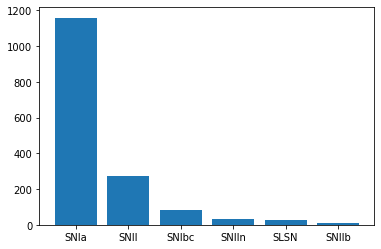


Datos luego de Oversampling Proporcional
SNIa     1159
SNII      825
SNIbc     246
SNIIn      96
SLSN       78
SNIIb      36
Name: classALeRCE, dtype: int64


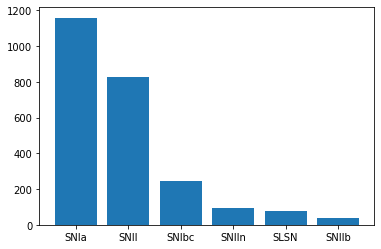

In [ ]:
Types=data['classALeRCE'].value_counts()
Tipos_SN=Types.index.to_numpy()
Ctdad_SN=Types.to_numpy()
print('Datos originales:')
print(Types)
fig, ax = plt.subplots()
ax.bar(Tipos_SN,Ctdad_SN)
fig.set_facecolor('white')
plt.show()

Types=Balanced_oversampler(data,3)['classALeRCE'].value_counts()
Tipos_SN=Types.index.to_numpy()
Ctdad_SN=Types.to_numpy()
print('')
print('Datos luego de Oversampling Proporcional')
print(Types)
fig, ax = plt.subplots()
ax.bar(Tipos_SN,Ctdad_SN)
fig.set_facecolor('white')
plt.show()

#Primer caso no Binario I: SNIa vs SNIbc vs SNII

In [ ]:
def train_val_test_oversampler(data,Oversampling=True,train_size=0.8,val_size=0.1):

  test_size=1-train_size-val_size
  val_prop=val_size/(val_size+train_size)


  #labels de todas las supernovas y botamos su nombre
  df=data.loc[:,:]
  df=df.drop(columns=['index'])

  #labels para separar train de test
  y=df.loc[:,['classALeRCE']]

  #Separación de train y test 
  df_train,df_test,Y_train,Y_test=train_test_split(df,y,stratify=y,test_size=test_size)

  df_train.reset_index(inplace=True)

  #Oversampling
  if Oversampling:
    resampled_df_train=Balanced_oversampler(df_train,3)
    resampled_Y_train=resampled_df_train.loc[:,['classALeRCE']]

    df_train=resampled_df_train

  #Labels para el clasificador no Binario
  df_train=df_train.replace(to_replace =["SNII","SNIIn","SNIIb"],value ="SNII") 
  df_test=df_test.replace(to_replace =["SNII","SNIIn","SNIIb"],value ="SNII") 

  #Eliminamos SLSN para esta versión 
  index_names = df_train[(df_train['classALeRCE'] == 'SLSN')].index 
  df_train.drop(index_names, inplace = True)   
  index_names = df_test[(df_test['classALeRCE'] == 'SLSN')].index 
  df_test.drop(index_names, inplace = True) 

  #lista de features
  features=list(df.columns.values)
  features.remove('classALeRCE')

  #Separación de features de labels
  X_train=df_train.loc[:,features]
  y_train=df_train.loc[:,['classALeRCE']]
  X_test=df_test.loc[:,features]
  y_test=df_test.loc[:,['classALeRCE']]

  #Creación conjunto validación
  X_train, X_val, y_train, y_val =train_test_split(X_train,y_train,stratify=y_train,
                                                test_size=val_prop)

  return   X_train,y_train,X_val,y_val,X_test,y_test

In [ ]:
def optimizador_v1(data,train_size,val_size,Kmin,Kmax,weights='uniform',std=False,oversampling=False,PcA=False, KPCA=False,gamma=0.001,RF=False):

  #weights puede ser 'uniform' o 'distance'
  #Oversampling llama a la funcion train_val_test_oversampler
  #std usa el standardScaler para normalizar y estandarizar los datos
  #PCA hace un PCA xd
  #Se optimiza según el balanced accuracy

  lista_acc=[]
  lista_bacc=[]
  lista_Ks=list(range(Kmin,Kmax+1))
  imp_features=['index', 'classALeRCE','SPM_gamma_1', 'delta_mjd_fid_1', 'SPM_tau_fall_1', 'SPM_tau_rise_1', 'IAR_phi_2',
                'first_mag_2', 'SPM_beta_1', 'SPM_gamma_2', 'GP_DRW_tau_2', 'g-r_max', 'MHPS_high_2', 
                'g-r_mean', 'Harmonics_mag_7_1', 'SPM_t0_1', 'mean_mag_2', 'MHPS_PN_flag_2', 
                'Harmonics_phase_7_1', 'SPM_t0_2', 'SPM_tau_fall_2', 'Power_rate_4' ]
  if RF:
    X_train,y_train,X_val,y_val,X_test,y_test =  train_val_test_oversampler(data[imp_features],
                                                                         Oversampling=oversampling,
                                                                         train_size=train_size,
                                                                         val_size=val_size)
  else:
    X_train,y_train,X_val,y_val,X_test,y_test =  train_val_test_oversampler(data,
                                                                         Oversampling=oversampling,
                                                                         train_size=train_size,
                                                                         val_size=val_size)
  

  #Separamos los conjuntos y aplicamos oversampling de ser necesario
  X_train,y_train,X_val,y_val,X_test,y_test =  train_val_test_oversampler(data,
                                                                         Oversampling=oversampling,
                                                                         train_size=train_size,
                                                                         val_size=val_size)
  
  #Formateamos todo a numpy y labels con ravel para convertir a fila 
  X_train=X_train.to_numpy()
  y_train=y_train.to_numpy().ravel()
  X_val=X_val.to_numpy()
  y_val=y_val.to_numpy().ravel()
  X_test=X_test.to_numpy()
  y_test=y_test.to_numpy().ravel()

  #y_train=Label_to_Num(y_train)
  #y_val=Label_to_Num(y_val)
  #y_test=Label_to_Num(y_test)

  if std:
    #Estandarización de datos 
    scaler=StandardScaler()
    scaler.fit(X_train)
    X_train=scaler.transform(X_train)
    X_val=scaler.transform(X_val)
    X_test=scaler.transform(X_test)

  #Realizamos el PCA
  if PcA:
    pca=PCA(0.95)
    pca.fit(X_train)
    n_comp=pca.n_components_
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test)

  if KPCA:
    Kpca=KernelPCA(n_components=58, kernel='rbf',gamma=gamma)
    Kpca.fit(X_train)
    X_train = Kpca.transform(X_train)
    X_val = Kpca.transform(X_val)
    X_test = Kpca.transform(X_test)

  #Se corre un clasificador para cada K y se guarda su accuracy normal y balanced
  for K in range(Kmin,Kmax+1):
    clf = neighbors.KNeighborsClassifier(K, weights=weights)
    clf.fit(X_train, y_train) 
    Pred_val = clf.predict(X_val)
    bacc=balanced_accuracy_score(y_val,Pred_val)   
    acc = accuracy_score(y_val,Pred_val)
    lista_acc.append(acc)
    lista_bacc.append(bacc)

  #Se busca el mejor de los clasificadores y se guarda
  Max_bacc = max(lista_bacc)
  Max_bacc_index = lista_bacc.index(max(lista_bacc))
  K_max_bacc=lista_Ks[Max_bacc_index]

  clf_opt=neighbors.KNeighborsClassifier(K_max_bacc, weights=weights)
  clf_opt.fit(X_train, y_train) 

  return clf_opt, X_train, y_train, X_val, y_val, X_test, y_test, Max_bacc


{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 19, 'p': 2, 'weights': 'distance'}
0.9560919540229885
0.6030890804597702


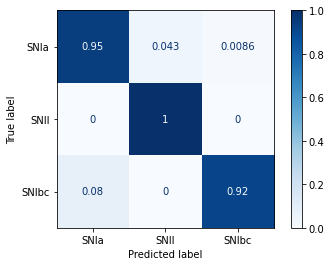

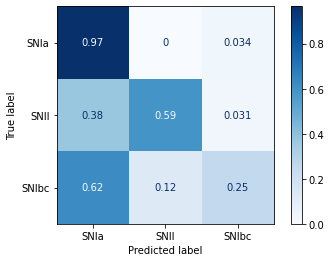

In [ ]:
#prueba
 
clf_opt, X_train, y_train, X_val, y_val, X_test, y_test,acc=optimizador_v1(
    data,
    train_size=0.8,
    val_size=0.1,
    Kmin=2,
    Kmax=25,
    weights='distance', #uniform o distance
    std= True,
    oversampling= True,
    PcA= not True,
    KPCA= not True,
    gamma=0.001,
    RF=True)

Pred_val = clf_opt.predict(X_val)
Pred_test = clf_opt.predict(X_test)
print(clf_opt.get_params())
print(acc)
bacc=balanced_accuracy_score(y_test,Pred_test) 
print(bacc)
plot_confusion_matrix(clf_opt,X_val,y_val,labels=['SNIa' , 'SNII' ,'SNIbc'],
                      cmap=plt.cm.Blues,normalize='true')
plot_confusion_matrix(clf_opt,X_test,y_test,labels=['SNIa' , 'SNII' ,'SNIbc'],cmap=plt.cm.Blues,normalize='true')

In [ ]:
def several_v1(N,data,train_size,val_size,Kmin,Kmax,weights='uniform',std=True,oversampling=False,PcA=False, KPCA=False,gamma=0.001,RF=False):
  #corre el optimizador N veces y saca el promedio y varianza de su balanced accuracy
  Bacc_list_v=[]
  Bacc_list_t=[]
  K_list=[]
  for i in range(N):
    clf_opt, X_train, y_train, X_val, y_val, X_test, y_test,bacc_v=optimizador_v1(
    data,train_size=train_size, val_size=val_size, Kmin=Kmin, Kmax=Kmax,
    weights=weights,std=std, oversampling=oversampling, PcA=PcA, KPCA=KPCA,gamma=gamma)

    Pred_test = clf_opt.predict(X_test)
    bacc_t=balanced_accuracy_score(y_test,Pred_test) 
    Bacc_list_v.append(bacc_v)
    Bacc_list_t.append(bacc_t)
    K_list.append(clf_opt.get_params()['n_neighbors'])
  print('')
  print('Experimento realizado % d veces' %N)
  print('')
  print('valores de K utilizados:')
  print(K_list)
  print('K promedio '+str(mean(K_list)))
  print('')
  print("Resultados de validación")
  print('Balanced Accuracy = ' + str(mean(Bacc_list_v)) + ' +/- ' + str(stdev(Bacc_list_v)))
  print('')
  print("Resultados de Test")
  print('Balanced Accuracy = ' + str(mean(Bacc_list_t)) + ' +/- ' + str(stdev(Bacc_list_t)))

several_v1(N=30,
           data=data,
           train_size=0.8,
           val_size=0.1,
           Kmin=1,Kmax=15,
           weights='uniform',
           std= True,
           oversampling= True,
           PcA= not True, 
           KPCA=not True,
           gamma=0.0001,
           RF= True)


Experimento realizado  30 veces

valores de K utilizados:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
K promedio 1

Resultados de validación
Balanced Accuracy = 0.9418408365261813 +/- 0.01744010633808153

Resultados de Test
Balanced Accuracy = 0.48996647509578545 +/- 0.03741343661440836


##Grid search "manual"

In [ ]:
def GS(data,train_size,val_size,Kmin,Kmax,std=True,oversampling=False,PcA=False, KPCA=False,RF=False):

  best_bacc=0
  Params=[]
  pesos = ['uniform','distance']
  kernels = ['rbf','poly','sigmoid']
  nucleo='sin kpca'
  gammas = np.linspace(0.0001, 0.01, num=10)
  imp_features=['index', 'classALeRCE','SPM_gamma_1', 'delta_mjd_fid_1', 'SPM_tau_fall_1', 'SPM_tau_rise_1', 'IAR_phi_2',
                'first_mag_2', 'SPM_beta_1', 'SPM_gamma_2', 'GP_DRW_tau_2', 'g-r_max', 'MHPS_high_2', 
                'g-r_mean', 'Harmonics_mag_7_1', 'SPM_t0_1', 'mean_mag_2', 'MHPS_PN_flag_2', 
                'Harmonics_phase_7_1', 'SPM_t0_2', 'SPM_tau_fall_2', 'Power_rate_4' ]
  if RF:
    X_train,y_train,X_val,y_val,X_test,y_test =  train_val_test_oversampler(data[imp_features],
                                                                         Oversampling=oversampling,
                                                                         train_size=train_size,
                                                                         val_size=val_size)
  else:
    X_train,y_train,X_val,y_val,X_test,y_test =  train_val_test_oversampler(data,
                                                                         Oversampling=oversampling,
                                                                         train_size=train_size,
                                                                         val_size=val_size)
  
  #Formateamos todo a numpy y labels con ravel para convertir a fila 
  X_train=X_train.to_numpy()
  y_train=y_train.to_numpy().ravel()
  X_val=X_val.to_numpy()
  y_val=y_val.to_numpy().ravel()
  X_test=X_test.to_numpy()
  y_test=y_test.to_numpy().ravel()

  #y_train=Label_to_Num(y_train)
  #y_val=Label_to_Num(y_val)
  #y_test=Label_to_Num(y_test)

  if std:
    #Estandarización de datos 
    scaler=StandardScaler()
    scaler.fit(X_train)
    X_train=scaler.transform(X_train)
    X_val=scaler.transform(X_val)
    X_test=scaler.transform(X_test)

  #Realizamos el PCA
  if PcA:
    pca=PCA(0.95)
    pca.fit(X_train)
    n_comp=pca.n_components_
    print( n_comp)
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test)

  for weights in pesos:
    for kernel in kernels:
      for gamma in gammas:
        for K in range(Kmin,Kmax+1):
          if KPCA:          
            Kpca=KernelPCA(n_components=58, kernel=kernel,gamma=gamma)
            Kpca.fit(X_train)
            X_train = Kpca.transform(X_train)
            X_val = Kpca.transform(X_val)
            X_test = Kpca.transform(X_test)

          clf = neighbors.KNeighborsClassifier(K, weights=weights)
          clf.fit(X_train, y_train) 
          Pred_val = clf.predict(X_val)
          bacc=balanced_accuracy_score(y_val,Pred_val)  
          if bacc>best_bacc:
            best_bacc=bacc
            Params=[K,weights,kernel,gamma] 
            nucleo=kernel
            X_train_opt=X_train
            X_val_opt=X_val
            X_test_opt=X_test

  #Se busca el mejor de los clasificadores y se guarda
  K_opt=Params[0]
  weights_opt=Params[1]
  nucleo=Params[2]
  gamma=Params[3]

  clf_opt=neighbors.KNeighborsClassifier(K_opt, weights=weights_opt)
  clf_opt.fit(X_train_opt, y_train) 
  
  return clf_opt, X_train_opt, y_train, X_val_opt, y_val, X_test_opt, y_test, K_opt, weights_opt,nucleo,gamma


K = 20
Weights: distance
Kernel: rbf
gamma: 0.0001
Balanced acc val: 0.9636781609195402
Balanced acc val: 0.5035919540229885


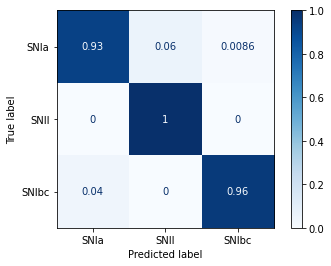

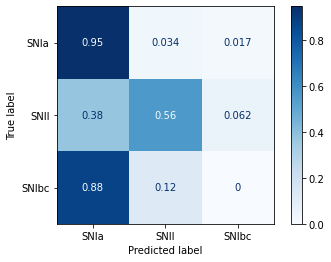

In [ ]:
#prueba de grid search
 
clf_opt, X_train, y_train, X_val, y_val, X_test, y_test,K,W,kernel,gamma=GS(
    data,
    train_size=0.8,
    val_size=0.1,
    Kmin=1,
    Kmax=25,
    std= True,
    oversampling= True,
    PcA= not True,
    KPCA= True,
    RF= not True)

print('K = ' + str(K))
print('Weights: '+W) 
print('Kernel: '+ kernel)
print('gamma: '+str(gamma))
Pred_val = clf_opt.predict(X_val)
Pred_test = clf_opt.predict(X_test)

print('Balanced acc val: ' + str(balanced_accuracy_score(y_val,Pred_val)))
print('Balanced acc val: ' + str(balanced_accuracy_score(y_test,Pred_test)))

plot_confusion_matrix(clf_opt,X_val,y_val,labels=['SNIa' , 'SNII' ,'SNIbc'],
                      cmap=plt.cm.Blues,normalize='true')
plot_confusion_matrix(clf_opt,X_test,y_test,labels=['SNIa' , 'SNII' ,'SNIbc'],cmap=plt.cm.Blues,normalize='true')

# Caso no binario II: SNI vs SNII vs SLSN

In [ ]:
def train_val_test_oversampler_v2(data,Oversampling=True,train_size=0.8,val_size=0.1):

  test_size=1-train_size-val_size
  val_prop=val_size/(val_size+train_size)

  #labels de todas las supernovas y botamos su nombre
  df=data.loc[:,:]
  df=df.drop(columns=['index'])

  #labels para separar train de test
  y=df.loc[:,['classALeRCE']]

  #Separación de train y test 
  df_train,df_test,Y_train,Y_test=train_test_split(df,y,stratify=y,test_size=test_size)


  df_train.reset_index(inplace=True)

  #Oversampling
  if Oversampling:
    resampled_df_train=Balanced_oversampler(df_train,3)
    resampled_Y_train=resampled_df_train.loc[:,['classALeRCE']]

    df_train=resampled_df_train

  #Labels para el clasificador no Binario
  df_train=df_train.replace(to_replace =["SNII","SNIIn","SNIIb"],value ="SNII") 
  df_test=df_test.replace(to_replace =["SNII","SNIIn","SNIIb"],value ="SNII")
  df_train=df_train.replace(to_replace =["SNIa","SNIbc"],value ="SNI") 
  df_test=df_test.replace(to_replace =["SNIa","SNIbc"],value ="SNI") 

  #lista de features
  features=list(df.columns.values)
  features.remove('classALeRCE')

  #Separación de features de labels
  X_train=df_train.loc[:,features]
  y_train=df_train.loc[:,['classALeRCE']]
  X_test=df_test.loc[:,features]
  y_test=df_test.loc[:,['classALeRCE']]

  #Creación conjunto validación
  X_train, X_val, y_train, y_val =train_test_split(X_train,y_train,stratify=y_train,
                                                 test_size=val_prop)

  return   X_train,y_train,X_val,y_val,X_test,y_test


def optimizador_v2(data,train_size,val_size,Kmin,Kmax,weights='uniform',std=True,oversampling=False,PcA=False, KPCA=False,gamma=0.0001,RF=False):

  #weights puede ser 'uniform' o 'distance'
  #Oversampling llama a la funcion train_val_test_oversampler
  #std usa el standardScaler para normalizar y estandarizar los datos
  #PCA hace un PCA xd
  #Se optimiza según el balanced accuracy

  lista_acc=[]
  lista_bacc=[]
  lista_Ks=list(range(Kmin,Kmax+1))
  imp_features=['index', 'classALeRCE','SPM_gamma_1', 'delta_mjd_fid_1', 'SPM_tau_fall_1', 'SPM_tau_rise_1', 'IAR_phi_2',
                'first_mag_2', 'SPM_beta_1', 'SPM_gamma_2', 'GP_DRW_tau_2', 'g-r_max', 'MHPS_high_2', 
                'g-r_mean', 'Harmonics_mag_7_1', 'SPM_t0_1', 'mean_mag_2', 'MHPS_PN_flag_2', 
                'Harmonics_phase_7_1', 'SPM_t0_2', 'SPM_tau_fall_2', 'Power_rate_4' ]
  if RF:
    X_train,y_train,X_val,y_val,X_test,y_test =  train_val_test_oversampler_v2(data[imp_features],
                                                                         Oversampling=oversampling,
                                                                         train_size=train_size,
                                                                         val_size=val_size)
  else:
    X_train,y_train,X_val,y_val,X_test,y_test =  train_val_test_oversampler_v2(data,
                                                                         Oversampling=oversampling,
                                                                         train_size=train_size,
                                                                         val_size=val_size)

  #Formateamos todo a numpy y labels con ravel para convertir a fila 
  X_train=X_train.to_numpy()
  y_train=y_train.to_numpy().ravel()
  X_val=X_val.to_numpy()
  y_val=y_val.to_numpy().ravel()
  X_test=X_test.to_numpy()
  y_test=y_test.to_numpy().ravel()

  #y_train=Label_to_Num(y_train)
  #y_val=Label_to_Num(y_val)
  #y_test=Label_to_Num(y_test)

  if std:
    #Estandarización de datos 
    scaler=StandardScaler()
    scaler.fit(X_train)
    X_train=scaler.transform(X_train)
    X_val=scaler.transform(X_val)
    X_test=scaler.transform(X_test)

  #Realizamos el PCA
  if PcA:
    pca=PCA(0.95)
    pca.fit(X_train)
    n_comp=pca.n_components_
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test)

  if KPCA:
    Kpca=KernelPCA(n_components=58, kernel='rbf',gamma=gamma)
    Kpca.fit(X_train)
    X_train = Kpca.transform(X_train)
    X_val = Kpca.transform(X_val)
    X_test = Kpca.transform(X_test)

  #Se corre un clasificador para cada K y se guarda su accuracy normal y balanced
  for K in range(Kmin,Kmax+1):
    clf = neighbors.KNeighborsClassifier(K, weights=weights)
    clf.fit(X_train, y_train) 
    Pred_val = clf.predict(X_val)
    bacc=balanced_accuracy_score(y_val,Pred_val)   
    acc = accuracy_score(y_val,Pred_val)
    lista_acc.append(acc)
    lista_bacc.append(bacc)

  #Se busca el mejor de los clasificadores y se guarda
  Max_bacc = max(lista_bacc)
  Max_bacc_index = lista_bacc.index(max(lista_bacc))
  K_max_bacc=lista_Ks[Max_bacc_index]
  clf_opt=neighbors.KNeighborsClassifier(K_max_bacc, weights=weights)
  
  clf_opt.fit(X_train, y_train) 

  return clf_opt, X_train, y_train, X_val, y_val, X_test, y_test, Max_bacc

0.9273809523809523
0.684923835125448


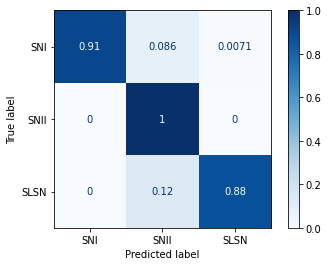

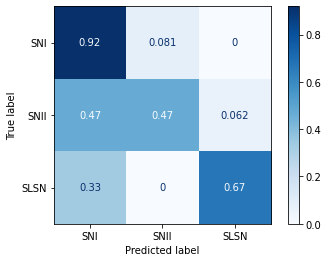

In [ ]:
#prueba
 
clf_opt, X_train, y_train, X_val, y_val, X_test, y_test, bacc_v=optimizador_v2(
    data,
    train_size=0.8,
    val_size=0.1,
    Kmin=1,
    Kmax=25,
    weights='uniform', #uniform o distance
    std= True,
    oversampling=  True,
    PcA=  True,
    KPCA= not True,
    gamma=0.0001,
    RF= not True)

Pred_val = clf_opt.predict(X_val)
Pred_test = clf_opt.predict(X_test)
print(balanced_accuracy_score(y_val,Pred_val) )
bacc=balanced_accuracy_score(y_test,Pred_test) 
print(bacc)
plot_confusion_matrix(clf_opt,X_val,y_val,labels=['SNI' , 'SNII' ,'SLSN'],
                      cmap=plt.cm.Blues,normalize='true')

plot_confusion_matrix(clf_opt,X_test,y_test,labels=['SNI' , 'SNII' ,'SLSN'],
                      cmap=plt.cm.Blues,normalize='true')

In [ ]:
def several_v2(N,data,train_size,val_size,Kmin,Kmax,weights='uniform',std=True,oversampling=False,PcA=False, KPCA=False,gamma=0.001,RF=False):
  #corre el optimizador N veces y saca el promedio y varianza de su balanced accuracy
  Bacc_list_v=[]
  Bacc_list_t=[]
  K_list=[]
  for i in range(N):
    clf_opt, X_train, y_train, X_val, y_val, X_test, y_test,bacc_v=optimizador_v2(
    data,train_size=train_size, val_size=val_size, Kmin=Kmin, Kmax=Kmax,
    weights=weights,std=std, oversampling=oversampling, PcA=PcA, KPCA=KPCA,gamma=gamma,RF=RF)

    Pred_test = clf_opt.predict(X_test)
    bacc_t=balanced_accuracy_score(y_test,Pred_test) 
    Bacc_list_v.append(bacc_v)
    Bacc_list_t.append(bacc_t)
    K_list.append(clf_opt.get_params()['n_neighbors'])
  print('')
  print('Experimento realizado % d veces' %N)
  print('')
  print('valores de K utilizados:')
  print(K_list)
  print('K promedio '+str(mean(K_list)))
  print('')
  print("Resultados de validación")
  print('Balanced Accuracy = ' + str(mean(Bacc_list_v)) + ' +/- ' + str(stdev(Bacc_list_v)))
  print('')
  print("Resultados de Test")
  print('Balanced Accuracy = ' + str(mean(Bacc_list_t)) + ' +/- ' + str(stdev(Bacc_list_t)))

several_v2(N=20,
           data=data,
           train_size=0.8,
           val_size=0.1,
           Kmin=1,Kmax=15,
           weights='uniform',
           std= True,
           oversampling= True,
           PcA= not True, 
           KPCA=  True,
           gamma=0.0001,
           RF=not True)

##Grid search para este caso

In [ ]:
def GS_v2(data,train_size,val_size,Kmin,Kmax,std=True,oversampling=False,PcA=False, KPCA=False,RF=False):

  best_bacc=0
  Params=[]
  pesos = ['uniform','distance']
  kernels = ['rbf','poly','sigmoid']
  nucleo='sin kpca'
  gammas = np.linspace(0.0001, 0.01, num=10)
  imp_features=['index', 'classALeRCE','SPM_gamma_1', 'delta_mjd_fid_1', 'SPM_tau_fall_1', 'SPM_tau_rise_1', 'IAR_phi_2',
                'first_mag_2', 'SPM_beta_1', 'SPM_gamma_2', 'GP_DRW_tau_2', 'g-r_max', 'MHPS_high_2', 
                'g-r_mean', 'Harmonics_mag_7_1', 'SPM_t0_1', 'mean_mag_2', 'MHPS_PN_flag_2', 
                'Harmonics_phase_7_1', 'SPM_t0_2', 'SPM_tau_fall_2', 'Power_rate_4' ]
  if RF:
    X_train,y_train,X_val,y_val,X_test,y_test =  train_val_test_oversampler_v2(data[imp_features],
                                                                         Oversampling=oversampling,
                                                                         train_size=train_size,
                                                                         val_size=val_size)
  else:
    X_train,y_train,X_val,y_val,X_test,y_test =  train_val_test_oversampler_v2(data,
                                                                         Oversampling=oversampling,
                                                                         train_size=train_size,
                                                                         val_size=val_size)
  
  #Formateamos todo a numpy y labels con ravel para convertir a fila 
  X_train=X_train.to_numpy()
  y_train=y_train.to_numpy().ravel()
  X_val=X_val.to_numpy()
  y_val=y_val.to_numpy().ravel()
  X_test=X_test.to_numpy()
  y_test=y_test.to_numpy().ravel()

  #y_train=Label_to_Num(y_train)
  #y_val=Label_to_Num(y_val)
  #y_test=Label_to_Num(y_test)

  if std:
    #Estandarización de datos 
    scaler=StandardScaler()
    scaler.fit(X_train)
    X_train=scaler.transform(X_train)
    X_val=scaler.transform(X_val)
    X_test=scaler.transform(X_test)

  #Realizamos el PCA
  if PcA:
    pca=PCA(0.95)
    pca.fit(X_train)
    n_comp=pca.n_components_
    print( n_comp)
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test)

  for weights in pesos:
    for kernel in kernels:
      for gamma in gammas:
        for K in range(Kmin,Kmax+1):
          if KPCA:          
            Kpca=KernelPCA(n_components=58, kernel=kernel,gamma=gamma)
            Kpca.fit(X_train)
            X_train = Kpca.transform(X_train)
            X_val = Kpca.transform(X_val)
            X_test = Kpca.transform(X_test)

          clf = neighbors.KNeighborsClassifier(K, weights=weights)
          clf.fit(X_train, y_train) 
          Pred_val = clf.predict(X_val)
          bacc=balanced_accuracy_score(y_val,Pred_val)  
          if bacc>best_bacc:
            best_bacc=bacc
            if not KPCA:
              Params=[K,weights,'sin kernel', 0] 
            if KPCA:
              Params=[K,weights,kernel,gamma] 
            X_train_opt=X_train
            X_val_opt=X_val
            X_test_opt=X_test

  #Se busca el mejor de los clasificadores y se guarda
  K_opt=Params[0]
  weights_opt=Params[1]
  nucleo=Params[2]
  gamma=Params[3]

  clf_opt=neighbors.KNeighborsClassifier(K_opt, weights=weights_opt)
  clf_opt.fit(X_train_opt, y_train) 
  
  return clf_opt, X_train_opt, y_train, X_val_opt, y_val, X_test_opt, y_test, K_opt, weights_opt,nucleo,gamma

In [ ]:
#Ejecución Grid Search
 
clf_opt, X_train, y_train, X_val, y_val, X_test, y_test,K,W,kernel,gamma=GS_v2(
    data,
    train_size=0.8,
    val_size=0.1,
    Kmin=2,
    Kmax=25,
    std=  True,
    oversampling= True,
    PcA= not True,
    KPCA=  True,
    RF=not True)

print('K = ' + str(K))
print('Weights: '+W) 
print('Kernel: '+ kernel)
print('gamma: '+str(gamma))
Pred_val = clf_opt.predict(X_val)
Pred_test = clf_opt.predict(X_test)

print('Balanced acc val: ' + str(balanced_accuracy_score(y_val,Pred_val)))
print('Balanced acc test: ' + str(balanced_accuracy_score(y_test,Pred_test)))

plot_confusion_matrix(clf_opt,X_val,y_val,labels=['SNI' , 'SNII' ,'SLSN'],
                      cmap=plt.cm.Blues,normalize='true')
plot_confusion_matrix(clf_opt,X_test,y_test,labels=['SNI' , 'SNII' ,'SLSN'],cmap=plt.cm.Blues,normalize='true')

#Caso Binario Ia vs No-Ia 
Se implementó luego de entregar el informe final del curso, con todas las técnicas desarrolladas para la clasificación no binaria (OS proporcional y reductores de dimensionalidad)

In [ ]:
def train_val_test_oversampler_Binary(data,Oversampling=True,train_size=0.8,val_size=0.1):

  test_size=1-train_size-val_size
  val_prop=val_size/(val_size+train_size)

  #labels de todas las supernovas y botamos su nombre
  df=data.loc[:,:]
  df=df.drop(columns=['index'])

  #labels para separar train de test
  y=df.loc[:,['classALeRCE']]

  #Separación de train y test 
  df_train,df_test,Y_train,Y_test=train_test_split(df,y,stratify=y,test_size=test_size)


  df_train.reset_index(inplace=True)

  #Oversampling
  if Oversampling:
    resampled_df_train=Balanced_oversampler(df_train,3)
    resampled_Y_train=resampled_df_train.loc[:,['classALeRCE']]

    df_train=resampled_df_train

  #Labels para el clasificador Binario
  df_train=df_train.replace(to_replace =["SNII","SNIIn","SNIIb","SNIbc","SLSN"],value ="No_Ia") 
  df_test=df_test.replace(to_replace = ["SNII","SNIIn","SNIIb","SNIbc","SLSN"],value ="No_Ia")

  #lista de features
  features=list(df.columns.values)
  features.remove('classALeRCE')

  #Separación de features de labels
  X_train=df_train.loc[:,features]
  y_train=df_train.loc[:,['classALeRCE']]
  X_test=df_test.loc[:,features]
  y_test=df_test.loc[:,['classALeRCE']]

  #Creación conjunto validación
  X_train, X_val, y_train, y_val =train_test_split(X_train,y_train,stratify=y_train,
                                                 test_size=val_prop)

  return   X_train,y_train,X_val,y_val,X_test,y_test


def optimizador_Binary(data,train_size,val_size,Kmin,Kmax,weights='uniform',std=True,oversampling=False,PcA=False, KPCA=False,gamma=0.0001,RF=False):

  #weights puede ser 'uniform' o 'distance'
  #Oversampling llama a la funcion train_val_test_oversampler
  #std usa el standardScaler para normalizar y estandarizar los datos
  #PCA hace un PCA xd
  #Se optimiza según el balanced accuracy

  lista_acc=[]
  lista_bacc=[]
  lista_Ks=list(range(Kmin,Kmax+1))
  imp_features=['index', 'classALeRCE','SPM_gamma_1', 'delta_mjd_fid_1', 'SPM_tau_fall_1', 'SPM_tau_rise_1', 'IAR_phi_2',
                'first_mag_2', 'SPM_beta_1', 'SPM_gamma_2', 'GP_DRW_tau_2', 'g-r_max', 'MHPS_high_2', 
                'g-r_mean', 'Harmonics_mag_7_1', 'SPM_t0_1', 'mean_mag_2', 'MHPS_PN_flag_2', 
                'Harmonics_phase_7_1', 'SPM_t0_2', 'SPM_tau_fall_2', 'Power_rate_4' ]
  if RF:
    X_train,y_train,X_val,y_val,X_test,y_test =  train_val_test_oversampler_Binary(data[imp_features],
                                                                         Oversampling=oversampling,
                                                                         train_size=train_size,
                                                                         val_size=val_size)
  else:
    X_train,y_train,X_val,y_val,X_test,y_test =  train_val_test_oversampler_Binary(data,
                                                                         Oversampling=oversampling,
                                                                         train_size=train_size,
                                                                         val_size=val_size)

  #Formateamos todo a numpy y labels con ravel para convertir a fila 
  X_train=X_train.to_numpy()
  y_train=y_train.to_numpy().ravel()
  X_val=X_val.to_numpy()
  y_val=y_val.to_numpy().ravel()
  X_test=X_test.to_numpy()
  y_test=y_test.to_numpy().ravel()

  #y_train=Label_to_Num(y_train)
  #y_val=Label_to_Num(y_val)
  #y_test=Label_to_Num(y_test)

  if std:
    #Estandarización de datos 
    scaler=StandardScaler()
    scaler.fit(X_train)
    X_train=scaler.transform(X_train)
    X_val=scaler.transform(X_val)
    X_test=scaler.transform(X_test)

  #Realizamos el PCA
  if PcA:
    pca=PCA(0.95)
    pca.fit(X_train)
    n_comp=pca.n_components_
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test)

  if KPCA:
    Kpca=KernelPCA(n_components=58, kernel='rbf',gamma=gamma)
    Kpca.fit(X_train)
    X_train = Kpca.transform(X_train)
    X_val = Kpca.transform(X_val)
    X_test = Kpca.transform(X_test)

  #Se corre un clasificador para cada K y se guarda su accuracy normal y balanced
  for K in range(Kmin,Kmax+1):
    clf = neighbors.KNeighborsClassifier(K, weights=weights)
    clf.fit(X_train, y_train) 
    Pred_val = clf.predict(X_val)
    bacc=balanced_accuracy_score(y_val,Pred_val)   
    acc = accuracy_score(y_val,Pred_val)
    lista_acc.append(acc)
    lista_bacc.append(bacc)

  #Se busca el mejor de los clasificadores y se guarda
  Max_bacc = max(lista_bacc)
  Max_bacc_index = lista_bacc.index(max(lista_bacc))
  K_max_bacc=lista_Ks[Max_bacc_index]
  clf_opt=neighbors.KNeighborsClassifier(K_max_bacc, weights=weights)
  
  clf_opt.fit(X_train, y_train) 

  return clf_opt, X_train, y_train, X_val, y_val, X_test, y_test, Max_bacc

0.9193157327586207
0.7958099438652766


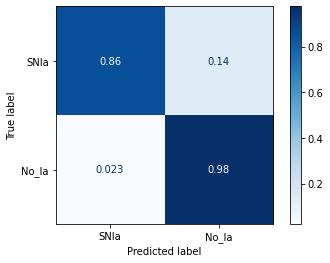

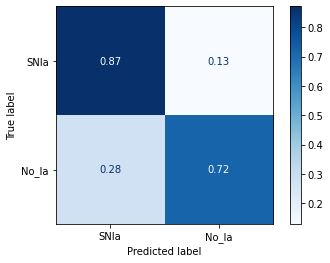

In [ ]:
#prueba Binaria
 
clf_opt, X_train, y_train, X_val, y_val, X_test, y_test, bacc_v=optimizador_Binary(
    data,
    train_size=0.8,
    val_size=0.1,
    Kmin=1,
    Kmax=25,
    weights='distance', #uniform o distance
    std=  True,
    oversampling=   True,
    PcA=  not True,
    KPCA= not True,
    gamma=0.001,
    RF=  True)

Pred_val = clf_opt.predict(X_val)
Pred_test = clf_opt.predict(X_test)
print(balanced_accuracy_score(y_val,Pred_val) )
bacc=balanced_accuracy_score(y_test,Pred_test) 
print(bacc)
plot_confusion_matrix(clf_opt,X_val,y_val,labels=['SNIa' , 'No_Ia'],
                      cmap=plt.cm.Blues,normalize='true')

plot_confusion_matrix(clf_opt,X_test,y_test,labels=['SNIa' , 'No_Ia'],
                      cmap=plt.cm.Blues,normalize='true')

#Caso completo: 6 clases

Al igual que el caso anterior, se implementó después de finalizado el informe final del curso

In [ ]:
def train_val_test_oversampler_v3(data,Oversampling=True,train_size=0.8,val_size=0.1):

  test_size=1-train_size-val_size
  val_prop=val_size/(val_size+train_size)

  #labels de todas las supernovas y botamos su nombre
  df=data.loc[:,:]
  df=df.drop(columns=['index'])

  #labels para separar train de test
  y=df.loc[:,['classALeRCE']]

  #Separación de train y test 
  df_train,df_test,Y_train,Y_test=train_test_split(df,y,stratify=y,test_size=test_size)


  df_train.reset_index(inplace=True)

  #Oversampling
  if Oversampling:
    resampled_df_train=Balanced_oversampler(df_train,4)
    resampled_Y_train=resampled_df_train.loc[:,['classALeRCE']]

    df_train=resampled_df_train

  #lista de features
  features=list(df.columns.values)
  features.remove('classALeRCE')

  #Separación de features de labels
  X_train=df_train.loc[:,features]
  y_train=df_train.loc[:,['classALeRCE']]
  X_test=df_test.loc[:,features]
  y_test=df_test.loc[:,['classALeRCE']]

  #Creación conjunto validación
  X_train, X_val, y_train, y_val =train_test_split(X_train,y_train,stratify=y_train,
                                                 test_size=val_prop)

  return   X_train,y_train,X_val,y_val,X_test,y_test


def optimizador_v3(data,train_size,val_size,Kmin,Kmax,weights='uniform',std=True,oversampling=False,PcA=False, KPCA=False,gamma=0.0001,RF=False):

  #weights puede ser 'uniform' o 'distance'
  #Oversampling llama a la funcion train_val_test_oversampler
  #std usa el standardScaler para normalizar y estandarizar los datos
  #PCA hace un PCA xd
  #Se optimiza según el balanced accuracy

  lista_acc=[]
  lista_bacc=[]
  lista_Ks=list(range(Kmin,Kmax+1))
  imp_features=['index', 'classALeRCE','SPM_gamma_1', 'delta_mjd_fid_1', 'SPM_tau_fall_1', 'SPM_tau_rise_1', 'IAR_phi_2',
                'first_mag_2', 'SPM_beta_1', 'SPM_gamma_2', 'GP_DRW_tau_2', 'g-r_max', 'MHPS_high_2', 
                'g-r_mean', 'Harmonics_mag_7_1', 'SPM_t0_1', 'mean_mag_2', 'MHPS_PN_flag_2', 
                'Harmonics_phase_7_1', 'SPM_t0_2', 'SPM_tau_fall_2', 'Power_rate_4' ]
  if RF:
    X_train,y_train,X_val,y_val,X_test,y_test =  train_val_test_oversampler_v3(data[imp_features],
                                                                         Oversampling=oversampling,
                                                                         train_size=train_size,
                                                                         val_size=val_size)
  else:
    X_train,y_train,X_val,y_val,X_test,y_test =  train_val_test_oversampler_v3(data,
                                                                         Oversampling=oversampling,
                                                                         train_size=train_size,
                                                                         val_size=val_size)
  print(y_train.value_counts())

  #Formateamos todo a numpy y labels con ravel para convertir a fila 
  X_train=X_train.to_numpy()
  y_train=y_train.to_numpy().ravel()
  X_val=X_val.to_numpy()
  y_val=y_val.to_numpy().ravel()
  X_test=X_test.to_numpy()
  y_test=y_test.to_numpy().ravel()

  #y_train=Label_to_Num(y_train)
  #y_val=Label_to_Num(y_val)
  #y_test=Label_to_Num(y_test)

  if std:
    #Estandarización de datos 
    scaler=StandardScaler()
    scaler.fit(X_train)
    X_train=scaler.transform(X_train)
    X_val=scaler.transform(X_val)
    X_test=scaler.transform(X_test)

  #Realizamos el PCA
  if PcA:
    pca=PCA(0.95)
    pca.fit(X_train)
    n_comp=pca.n_components_
    print( n_comp)
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test)

  if KPCA:
    Kpca=KernelPCA(n_components=58, kernel='rbf',gamma=0.001)
    Kpca.fit(X_train)
    X_train = Kpca.transform(X_train)
    X_val = Kpca.transform(X_val)
    X_test = Kpca.transform(X_test)

  #Se corre un clasificador para cada K y se guarda su accuracy normal y balanced
  for K in range(Kmin,Kmax+1):
    clf = neighbors.KNeighborsClassifier(K, weights=weights)
    clf.fit(X_train, y_train) 
    Pred_val = clf.predict(X_val)
    bacc=balanced_accuracy_score(y_val,Pred_val)   
    acc = accuracy_score(y_val,Pred_val)
    lista_acc.append(acc)
    lista_bacc.append(bacc)

  #Se busca el mejor de los clasificadores y se guarda
  Max_bacc = max(lista_bacc)
  Max_bacc_index = lista_bacc.index(max(lista_bacc))
  K_max_bacc=lista_Ks[Max_bacc_index]
  clf_opt=neighbors.KNeighborsClassifier(K_max_bacc, weights=weights)
  
  clf_opt.fit(X_train, y_train) 

  return clf_opt, X_train, y_train, X_val, y_val, X_test, y_test, Max_bacc

classALeRCE
SNIa           927
SNII           878
SNIbc          263
SNIIn          103
SLSN            82
SNIIb           39
dtype: int64
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
0.9675287356321839
0.38707580733442803


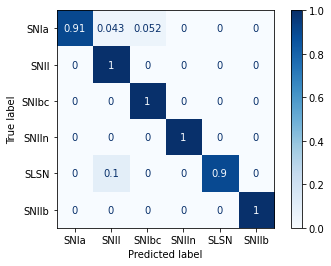

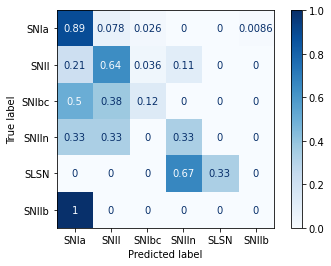

In [ ]:
#prueba 6 clases 
 
clf_opt, X_train, y_train, X_val, y_val, X_test, y_test, bacc_v=optimizador_v3(
    data,
    train_size=0.8,
    val_size=0.1,
    Kmin=1,
    Kmax=15,
    weights='distance', #uniform o distance
    std= True,
    oversampling=  True,
    PcA= not True,
    KPCA= not True,
    gamma=0.0001,
    RF=True)

Pred_val = clf_opt.predict(X_val)
Pred_test = clf_opt.predict(X_test)
print(clf_opt.get_params())
print(balanced_accuracy_score(y_val,Pred_val) )
bacc=balanced_accuracy_score(y_test,Pred_test) 
print(bacc)
plot_confusion_matrix(clf_opt,X_val,y_val,labels=['SNIa' , 'SNII' ,'SNIbc','SNIIn','SLSN','SNIIb'],
                      cmap=plt.cm.Blues,normalize='true')

plot_confusion_matrix(clf_opt,X_test,y_test,labels=['SNIa' , 'SNII' ,'SNIbc','SNIIn','SLSN','SNIIb'],
                      cmap=plt.cm.Blues,normalize='true')